Reproducing "Fundamental limitations of the eigenvalue continuation approach", https://arxiv.org/abs/2202.07493


In [10]:
def build_matrix_realization(H0,H1,g):
    return matrix(RDF, H0 + H1*g)

In [60]:
H0 = matrix(RDF,[[1,0.1,0],[0.1,2,0.5],[0,0.5,4]])  
H1 = matrix(RDF,[[2.,0,0],[0,0,0],[0,0,-2.]])   
#H0 = matrix(RDF,[[1,0,0],[0.1,2,0.3],[0,0.0,3]])  
#H1 = matrix(RDF,[[0.,0,9.8],[0,0,0],[0,1.2,0]])   

#H0 = matrix(RDF,[[1,0,0,0,0],[0,0.1,0.1,2,0.3],[0,0.0,3,2,0],[0,0,0,3.2,0],[0,0,0,0,5]])  
#H1 = matrix(RDF,[[-2,0,-9.8,0,1],[0,0.018,0,0,0.1],[0.1,1.2,0,0.2,0.0],[12,0,0,0,1],[1,0,0,0,4]]) 

In [61]:
H0

[1.0 0.1 0.0]
[0.1 2.0 0.5]
[0.0 0.5 4.0]

In [62]:
H1

[ 2.0  0.0  0.0]
[ 0.0  0.0  0.0]
[ 0.0  0.0 -2.0]

In [63]:
g = var("g", domain="real")

In [64]:
H = H0 + g * H1
smallest_eigenval(g) = H.eigenvalues()[1].real_part()
H

[ 2.0*g + 1.0          0.1          0.0]
[         0.1          2.0          0.5]
[         0.0          0.5 -2.0*g + 4.0]

<ipython-input-69-b21c80bf0177>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  evs[:,i] = np.sort(w)


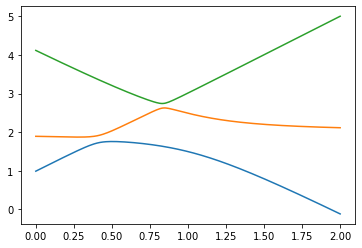

In [69]:
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt

def plot_eigenvals(H0,H1,num_evs=3,ev_range=(0,2)):
    evs = np.zeros((num_evs,200))
    couplings = np.linspace(ev_range[0],ev_range[1],200)
    for i, c in enumerate(couplings):
        mat = np.array(H0) + c * np.array(H1)
        w,v = sc.linalg.eig(mat)
        evs[:,i] = np.sort(w)
        
    for i in range(num_evs):
        plt.plot(couplings, evs[i,:])
    
    plt.show()

plot_eigenvals(H0,H1)
#plot_eigenvals(H0,H1,num_evs=5,ev_range=(0,0.2))

In [70]:
def extract_gs_eigenvector(H):
    return matrix(RDF, H.eigenvectors_right()[2][1]).transpose()

ga = 1.4
gb = 1.7

g_target = 1

H_target = build_matrix_realization(H0,H1,g_target)

actual_ev_target = smallest_eigenval(g_target)

eva = extract_gs_eigenvector(build_matrix_realization(H0,H1,ga))
evb = extract_gs_eigenvector(build_matrix_realization(H0,H1,gb))

HEC11 = (eva.T *  H_target * eva)[0][0]
HEC12 = (eva.T *  H_target * evb)[0][0]
HEC22 = (evb.T *  H_target * evb)[0][0]
HEC21 = (evb.T *  H_target * eva)[0][0]

N11 = (eva.T * eva)[0][0]
N12 = (eva.T * evb)[0][0]
N22 = (evb.T * evb)[0][0]
N21 = (evb.T * eva)[0][0]

HEC = matrix(RDF, [[HEC11, HEC12],[HEC21, HEC22]])
N   = matrix(RDF, [[N11, N12],[N21, N22]])

EC_ev_target =  min((N.inverse() * HEC).eigenvalues())
pct_diff = 100*(EC_ev_target - actual_ev_target)/actual_ev_target

print("Target Hamiltonian, too solve approximately:")
print(H_target)
print("\nProjection of target Hamiltonian onto training subspace")
print(HEC)
print("Eigenvector continuation: {:1.6f}, Exact: {:1.6f}, pct difference: {:1.6f}"
      .format(float(EC_ev_target),float(actual_ev_target),float(pct_diff)))


Target Hamiltonian, too solve approximately:
[3.0 0.1 0.0]
[0.1 2.0 0.5]
[0.0 0.5 2.0]

Projection of target Hamiltonian onto training subspace
[1.6078931110369605 1.6358109221757586]
[1.6358109221757584 1.7086388386592892]
Eigenvector continuation: 1.496996, Exact: 1.496663, pct difference: 0.022235


In [71]:
# now, implement it fast 
from matplotlib import pyplot as plt


def build_matrix(H0, H1, g):
    return H0 + g * H1

def matrix_min_eigenvec(matrix : np.array, gen_mat=None):
    w,vr =  sc.linalg.eig(matrix, b=gen_mat)
    return np.min(w), vr[:,np.argmin(w)]
    
def vec_hermitian_ip(vec1 : np.array, vec2 : np.array):
    return np.dot(vec1.conj(), vec2)

def train_EC(training_set : list, test_dimensions, training_dimensions, hf_min_eigenvec=matrix_min_eigenvec ):
    
    # eigenvectors of each training hamiltonian as column vectors
    subspace_basis = np.zeros((training_dimensions, test_dimensions))
    
    for i in range(0, training_dimensions):
        # each training Hamiltonian must have 
        assert(training_set[i].shape[0] == test_dimensions)
        # get high fidelity data for each element of test space
        w, v = hf_min_eigenvec(training_set[i])
        subspace_basis[i,:] = v
        
    return subspace_basis
        
def run_EC(target_hamiltonian : np.array, subspace_basis: np.array, inner_product=vec_hermitian_ip):
    # target Hamiltonian must be 2D square matrix
    assert(len(target_hamiltonian.shape) == 2)
    assert(target_hamiltonian.shape[0] == target_hamiltonian.shape[1])
    
    # each column vector in subspace basis must have same dimensionality as 
    # target Hamiltonian
    training_dimensions, basis_size = subspace_basis.shape
    assert(basis_size == target_hamiltonian.shape[0])
    assert(basis_size > training_dimensions)

    EC_Hamiltonian = np.zeros((training_dimensions, training_dimensions), dtype=float)
    N = np.zeros((training_dimensions, training_dimensions), dtype=float)

    for i in range(training_dimensions):
        for j in range(training_dimensions):
            N[i,j] = inner_product( subspace_basis[i,:], subspace_basis[j,:] )
            EC_Hamiltonian[i,j] = inner_product(subspace_basis[i,:], target_hamiltonian @ subspace_basis[j,:])
    
    w, v = matrix_min_eigenvec(EC_Hamiltonian, gen_mat=N)
    return w, v

# build training hamiltonians
training_couplings = [ga, gb]

H0 = np.array(H0)
H1 = np.array(H1)

training_set = []
for g in training_couplings:
    training_set.append(np.array(build_matrix(H0,H1,g)))

# train model by solving training hamiltonians
train_dimensions = len(training_set)
test_dimensions = training_set[0].shape[0]
subspace_basis = train_EC(training_set, test_dimensions, train_dimensions )

# run EC for a target Hamiltonian
target_H = np.array(build_matrix(H0,H1,g_target))
actual_ev_target, _ = matrix_min_eigenvec(target_H)
EC_ev_target    , _ = run_EC(target_H, subspace_basis)
pct_diff = 100*(EC_ev_target - actual_ev_target)/actual_ev_target

print("Target Hamiltonian, too solve approximately:")
print(target_H)
print("Eigenvector continuation: {:1.6f}, Exact: {:1.6f}, pct difference: {:1.6f}"
      .format(float(EC_ev_target), actual_ev_target, pct_diff))

Target Hamiltonian, too solve approximately:
[[3.  0.1 0. ]
 [0.1 2.  0.5]
 [0.  0.5 2. ]]
Eigenvector continuation: 1.496996, Exact: 1.496663+0.000000j, pct difference: 0.022235+0.000000j


<ipython-input-71-3f53c9a95504>:75: ComplexWarning: Casting complex values to real discards the imaginary part
  .format(float(EC_ev_target), actual_ev_target, pct_diff))


<ipython-input-75-6ae0fb82b4ab>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  test_ev[i], _ = run_EC(target_H, subspace_basis)


For training set: 0, L2 is 1.56282+0.00000j
For training set: 1, L2 is 6.73623+0.00000j
For training set: 2, L2 is 3.27836+0.00000j
For training set: 3, L2 is 2.42235+0.00000j


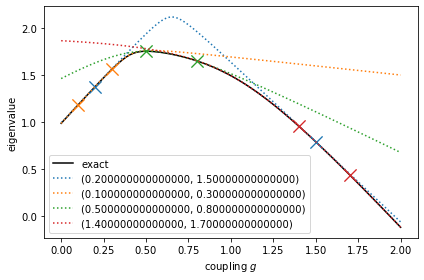

In [75]:
# batch function
def run_EC_coupling(subspace_basis, test_couplings, H0, H1):
    test_ev = np.zeros(len(test_couplings))
    for i in range(len(test_couplings)):
        g = test_couplings[i]
        target_H = np.array(build_matrix_realization(H0,H1,g))
        test_ev[i], _ = run_EC(target_H, subspace_basis)
    
    return test_ev

        
# compare trained EC to analytic eigenvalue
coupling = np.linspace(0.0,2, 100, dtype=float)
def sme(g):
    w,_ = matrix_min_eigenvec(np.array(build_matrix(H0,H1,g)))
    return w

smallest_ev_exact = np.array([sme(g) for g in coupling])

plt.plot(coupling, smallest_ev_exact, 'k', label="exact")
training_pairs = [(0.2,1.5), (0.1,0.3), (0.5,0.8), (1.4,1.7)]
#training_pairs = [(0.5,1.25,8), (0.1,6), (1.4,1.7)]

for i,t in enumerate(training_pairs):
    training_set = []
    for g in t:
        training_set.append(np.array(build_matrix(H0,H1,g)))
    
    train_dimensions = len(training_set)
    test_dimensions = training_set[0].shape[0]
    subspace_basis = train_EC(training_set, test_dimensions, train_dimensions )
    ec_eval = run_EC_coupling(subspace_basis, coupling, H0, H1)
    p = plt.plot(coupling, ec_eval, ":", label=t)
    for g in t:
        ec_g,_ = run_EC( np.array(build_matrix_realization(H0,H1,g)), subspace_basis)
        plt.plot([g,g], [ec_g, ec_g], p[0].get_color(), marker="x", markersize=12)
    
    l2 = np.sqrt(np.dot(smallest_ev_exact - ec_eval, smallest_ev_exact - ec_eval))
    print("For training set: {}, L2 is {:1.5f}".format(i, l2))

#plt.xlim([0,2])
#plt.ylim([0,2.5])
plt.xlabel(r"coupling $g$")
plt.ylabel(r"eigenvalue")
plt.legend()
plt.tight_layout()


